# Disability at six month follow up

## Aims

Data on disability at six month follow up is not missing at random.

Investigating factors that relate to:
* Whether patients have a record of disability at six months
* Patients disability score/change in disability between discharge and follow up

This analysis has been repeated using the whole dataset (only filtered by number of admissions at hospital per year) as will as the filtered dataset (only patients who arrived within four hours of known stroke onset).

## Set up

In [1]:
# Import packages and functions
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Descriptive

### Completion

This section summarises the completion rate for disability scores at each timepoint. As we would anticipate, no-one marked as having died (which we understand to mean they were not discharged following arrival as they died), has a 6-month follow-up. Hence, summaries of completion are repeated, but for individuals who were alive at discharge.

In [4]:
def count_missing(df):
    '''
    Find count and proportion of people missing disability at each timepoint
    df: pandas dataframe
    '''
    # Mark whether disability is present at each timepoint or not
    mrs_missing = (
        df[['prior_disability',
            'discharge_disability',
            'disability_6_month']]
        .isnull()
        .apply(lambda x: x.map({True: 'Missing', False: 'Not missing'})))

    # Count patterns of missing or not between variables
    mrs_complete = (
        mrs_missing
        .value_counts()
        .reset_index(name='count')
        .sort_values(by='disability_6_month', ascending=False))

    # Convert counts to proportions and display results
    mrs_complete['percentage'] = (
        mrs_complete['count'] / mrs_complete['count'].sum())*100
    print('\nCompletion of disability data:')
    display(mrs_complete)
    return (mrs_missing)


def disability_known_death(df):
    '''
    Add columns indicating whether disability at 6 months was known
    (and return dataframe with that column added). Print the relationship
    between death and disability at 6 months (should see no individuals
    who died have follow-up)
    df: pandas dataframe
    '''
    # Add column indicating whether disability at 6 months was known
    df['disability_6_month_known'] = (
        df['disability_6_month']
        .isnull()
        .map({True: 'No (missing)', False: 'Yes (present)'}))

    # View relationship between death and 6 month follow up
    print('\nSee no individuals who died had follow-up:')
    display(df
            .groupby('disability_6_month_known')['death']
            .value_counts(dropna=False)
            .reset_index(name='count'))
    return (df)


def count_alive_missing(df, mrs_missing):
    '''
    Find count and proportion of people missing disability at each timepoint
    Focussing only on individuals who were alive at discharge
    '''
    # Add death
    mrs_missing['death'] = df['death']

    # Count proportion missing data
    mrs_complete_alive = (
        mrs_missing[mrs_missing['death'] == 0]
        .value_counts()
        .reset_index(name='count')
        .sort_values(by='disability_6_month', ascending=False))
    mrs_complete_alive['percentage'] = (
        mrs_complete_alive['count'] / mrs_complete_alive['count'].sum())*100
    print('Completion of disability data (for patients alive at discharge):')
    display(mrs_complete_alive)

In [5]:
print('For patients who arrive within four hours of known onset...')
mrs_missing_data = count_missing(data)
data = disability_known_death(data)
count_alive_missing(data, mrs_missing_data)

For patients who arrive within four hours of known onset...

Completion of disability data:


,prior_disability,discharge_disability,disability_6_month,count,percentage
1,Not missing,Not missing,Not missing,39167,28.585087
0,Not missing,Not missing,Missing,96845,70.679979
2,Not missing,Missing,Missing,1007,0.734935



See no individuals who died had follow-up:


,disability_6_month_known,death,count
0,No (missing),0.0,74322
1,No (missing),1.0,23526
2,No (missing),NaN,4
3,Yes (present),0.0,39167


Completion of disability data (for patients alive at discharge):


,prior_disability,discharge_disability,disability_6_month,death,count,percentage
1,Not missing,Not missing,Not missing,0.0,39167,34.511715
0,Not missing,Not missing,Missing,0.0,73320,64.605380
2,Not missing,Missing,Missing,0.0,1002,0.882905


In [6]:
print('For all patients...')
mrs_missing_data_full = count_missing(data_full)
data_full = disability_known_death(data_full)
count_alive_missing(data_full, mrs_missing_data_full)

For all patients...



Completion of disability data:


,prior_disability,discharge_disability,disability_6_month,count,percentage
1,Not missing,Not missing,Not missing,109321,30.461375
0,Not missing,Not missing,Missing,247034,68.833941
2,Not missing,Missing,Missing,2529,0.704685



See no individuals who died had follow-up:


,disability_6_month_known,death,count
0,No (missing),0.0,199725
1,No (missing),1.0,49828
2,No (missing),NaN,10
3,Yes (present),0.0,109321


Completion of disability data (for patients alive at discharge):


,prior_disability,discharge_disability,disability_6_month,death,count,percentage
1,Not missing,Not missing,Not missing,0.0,109321,35.373698
0,Not missing,Not missing,Missing,0.0,197208,63.811860
2,Not missing,Missing,Missing,0.0,2517,0.814442


### Filter to alive at discharge

In [7]:
# All patients
data_full_alive = data_full[data_full['death'] == 0]
# Patients who arrive within four hours of known onset
data_alive = data[data['death'] == 0]

### Comparing patients followed up with those not

We see a marked difference in stroke severity, but not when only focus on those alive at discharge.

Regardless of whether alive at discharge, we see a higher proportion who were thrombolysed have follow-up. This is less so when focus on all patients, and more so when focus on patients who arrived within 4 hours of known stroke onset.

In [8]:
def compare_follow_up(df):
    '''
    Compare those with follow-up to those not in terms of:
    - Stroke severity
    - Whether they were thrombolysed
    '''
    # Stroke severity
    display(df
            .groupby('disability_6_month_known')['stroke_severity']
            .describe())

    # Thrombolysis
    display(df
            .groupby('thrombolysis')['disability_6_month_known']
            .value_counts(normalize=True)
            .reset_index(name='proportion'))

In [9]:
print('For patients who arrived within 4 hours of known stroke onset...')
print('All patients (inc. dead at discharge):')
compare_follow_up(data)
print('Patients who were alive at discharge:')
compare_follow_up(data_alive)

For patients who arrived within 4 hours of known stroke onset...
All patients (inc. dead at discharge):


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),97852.0,9.689889,8.756325,0.0,3.0,6.0,15.0,42.0
Yes (present),39167.0,6.995940,6.499562,0.0,2.0,5.0,10.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.725331
1,0,Yes (present),0.274669
2,1,No (missing),0.687080
3,1,Yes (present),0.312920


Patients who were alive at discharge:


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),74322.0,7.040728,6.637187,0.0,2.0,5.0,10.0,42.0
Yes (present),39167.0,6.995940,6.499562,0.0,2.0,5.0,10.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.662091
1,0,Yes (present),0.337909
2,1,No (missing),0.638498
3,1,Yes (present),0.361502


In [10]:
print('For all patients (including those who were dead at discharge):')
compare_follow_up(data_full)
print('For all patients who were alive at discharge:')
compare_follow_up(data_full_alive)

For all patients (including those who were dead at discharge):


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),249563.0,7.802042,8.299545,0.0,2.0,4.0,11.0,42.0
Yes (present),109321.0,5.370002,5.683979,0.0,2.0,3.0,7.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.696475
1,0,Yes (present),0.303525
2,1,No (missing),0.686979
3,1,Yes (present),0.313021


For all patients who were alive at discharge:


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),199725.0,5.511238,5.949742,0.0,2.0,3.0,7.0,42.0
Yes (present),109321.0,5.370002,5.683979,0.0,2.0,3.0,7.0,42.0


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.647322
1,0,Yes (present),0.352678
2,1,No (missing),0.638126
3,1,Yes (present),0.361874


### Disability at 6 month follow up

**Change in disability**

We received a comment that we expect people to, on average, be 1 unit better.

We see that Rankin score from discharge to follow-up is, on average, the same (median) or worse (mean) (focussing only on people who have measurements at both time points).

Caveats include:
* mRS is an ordinal scale (i.e. they have an order but there is not a consistent space on the scale between each score) (hence why some of the other analyses on SAMueL2 use utility values)

In [11]:
def disability_change(df):
    # Change in mRS score from discharge to 6 months later
    mrs_6m = ((df['disability_6_month'] - df['discharge_disability'])
              .dropna().describe())

    print(f'''From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is {mrs_6m.squeeze()['mean']:.1f}''')
    display(mrs_6m)


def plot_disability_change(df):
    # Extract individuals with complete data at followup
    mrs_compare = (df[['disability_6_month', 'discharge_disability']]
                   .dropna()
                   .rename(columns={'disability_6_month': 'followup',
                                    'discharge_disability': 'discharge'}))

    # Compare 6 month disability to discharge disability
    mrs_compare['compare'] = np.where(
        mrs_compare['followup'] > mrs_compare['discharge'], 'Worse',
        np.where(mrs_compare['followup'] < mrs_compare['discharge'],
                 'Better', 'Same'))

    # Find proportion better, same or worse - by discharge disability
    mrs_compare_3 = (
        mrs_compare.groupby('discharge')['compare']
        .value_counts(normalize=True)
        .reset_index(name='prop')
        .sort_values(by=['discharge', 'compare'])
        .pivot(index='discharge',
               columns='compare',
               values='prop')
        .fillna(0))

    # Plot these results
    fig, ax = plt.subplots(figsize=(9, 6))
    mrs_compare_3.plot.bar(ax=ax)
    ax.set_xlabel('Discharge disability')
    ax.set_ylabel('Proportion of patients')
    ax.legend(title='Disability at 6 months (compared to discharge)',
              loc='upper center', ncol=3)
    ax.set_title('For each discharge mRS score, proportion of patients' +
                 '\nwho had better, same or worse score at 6-month follow-up')
    plt.show()


def plot_follow_up_by_discharge(df):
    # Find proportion with each disability at 6 months,
    # grouped by discharge disability
    followup = (df
                .groupby('discharge_disability')['disability_6_month']
                .value_counts(normalize=True, dropna=False)
                .reset_index(name='prop')
                .sort_values(by=['discharge_disability',
                                 'disability_6_month']))

    # Pivot those results so they're suitable for plot
    followup_p = (followup
                  .dropna()
                  .pivot(columns='disability_6_month',
                         index='discharge_disability',
                         values='prop'))

    # Create plot (line plot as easier to see difference in proportions)
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(followup_p.T, marker='o')
    ax.set_xlabel('Disability at 6-month follow-up (mRS score)')
    ax.set_ylabel('Proportion of patients')
    ax.legend(ax.get_lines(), followup_p.columns, loc='best',
              title='Discharge disability', ncol=2)
    ax.set_title('Proportion of patients with each 6-month disability score' +
                 '\n(grouped by their discharge disability score)')
    ax.grid()
    plt.show()

For patients with disability at discharge and 6 months
who had arrived within 4 hours of known stroke onset...

From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is 0.1


count    39167.000000
mean         0.101182
std          1.516493
min         -5.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          6.000000
dtype: float64

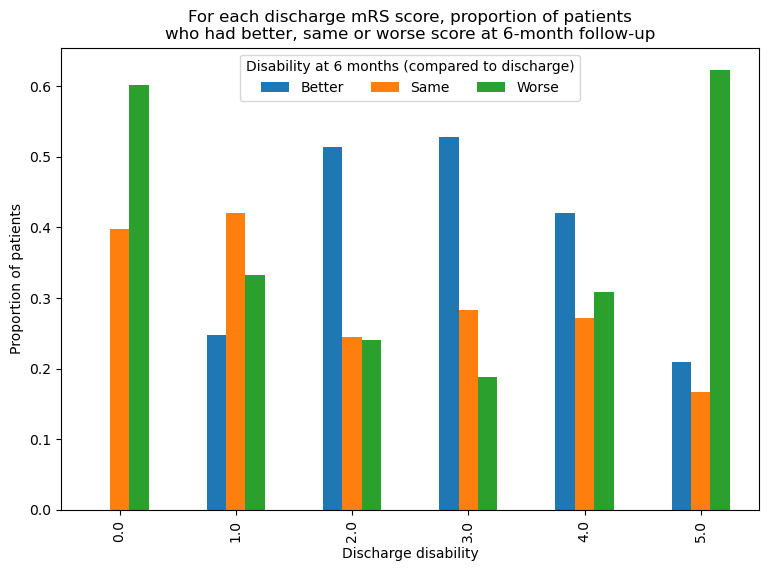

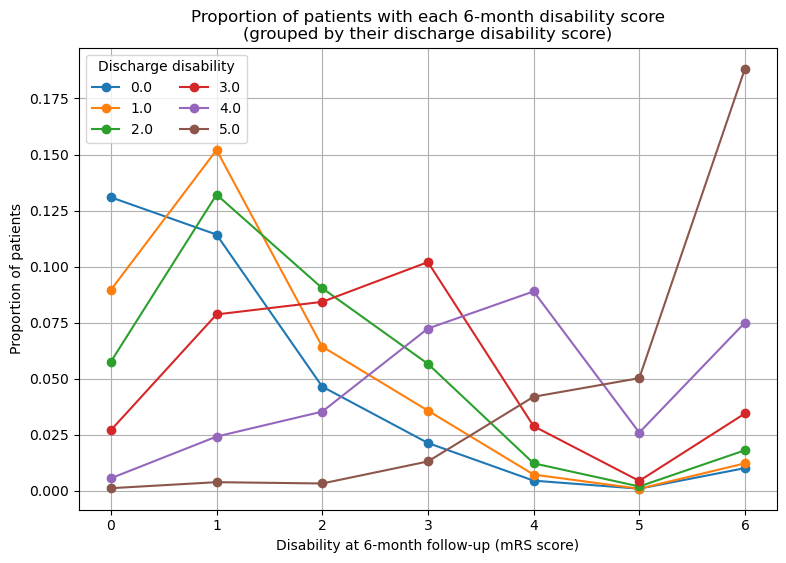

In [12]:
print('For patients with disability at discharge and 6 months')
print('who had arrived within 4 hours of known stroke onset...\n')
disability_change(data)
test = plot_disability_change(data)
plot_follow_up_by_discharge(data)

For all patients with scores at both times...

From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is 0.1


count    109321.00000
mean          0.11533
std           1.52376
min          -5.00000
25%          -1.00000
50%           0.00000
75%           1.00000
max           6.00000
dtype: float64

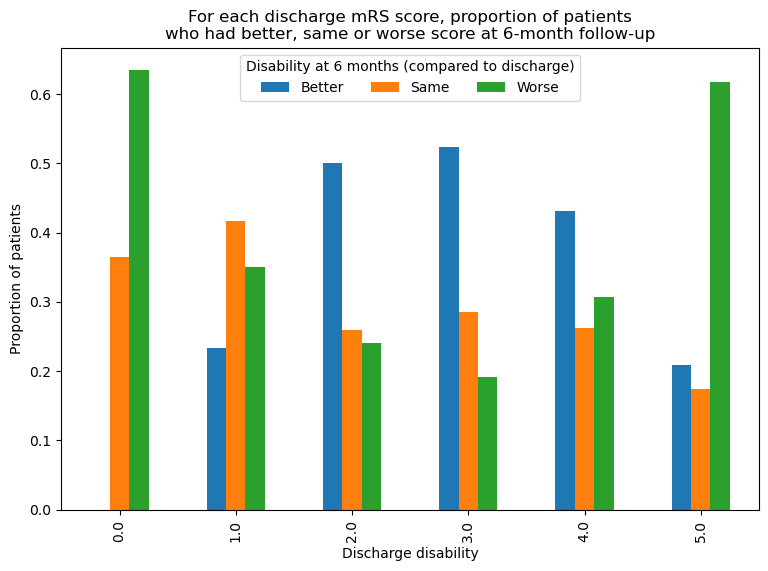

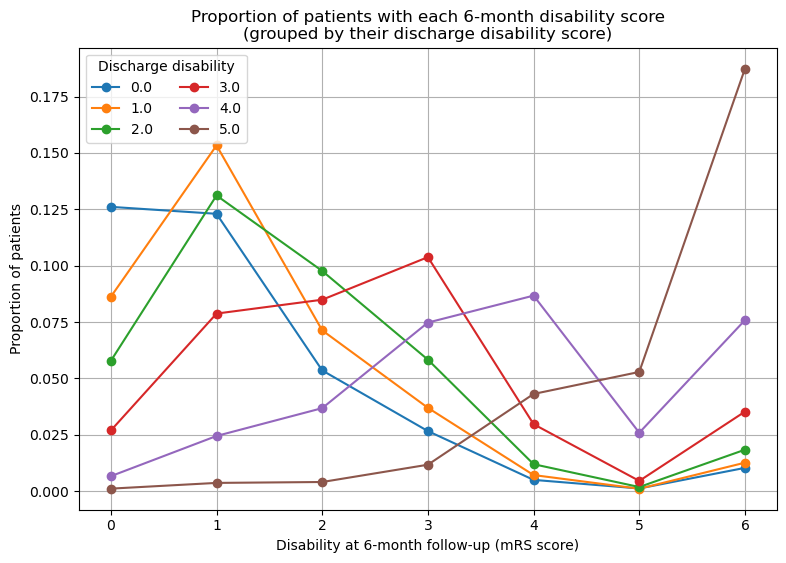

In [13]:
print('For all patients with scores at both times...\n')
disability_change(data_full)
plot_disability_change(data_full)
plot_follow_up_by_discharge(data_full)

## Regression (change in disability)

We are using a multiple linear regression model, with estimation using ordinary least squares (OLS).

Caveat:
* Data is not missing at random
* mRS score is ordinal scale

### Dataset

The dataset is patients who arrived within 4 hours of known onset, and who have complete data at each disability timepoint, as well as for stroke severity, age and whether thrombolysed.

In those model, we are predicting change in disability from discharge to six month follow up.

In [14]:
# Extract relevant columns and drop rows with NA
reg_df = data[['prior_disability', 'stroke_severity', 'age',
               'thrombolysis', 'discharge_disability',
               'disability_6_month']].dropna().reset_index()
display(reg_df.shape)

# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['disability_6_month'] - reg_df['discharge_disability']

(39167, 7)

### Transform data, fit model, and collect evaluation metrics

In [15]:
def standardise_data(X_train, X_test):
    '''
    Put features on a similar scale through standardisation.
    Just transforms features (not response/target variable).
    Invovles subtracting mean and dividing by standard deviation (SD)
    of each feature, so data have mean of 0 and SD of 1.
    Test data is standardised on training data mean and SD.
    '''

    # Set up scaling object and fit on training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Apply scaling to training and test data
    train_std = sc.transform(X_train)
    test_std = sc.transform(X_test)

    return train_std, test_std

In [16]:
def run_regression(standardise):
    '''
    Run regression with 5-fold cross-validation
    Can choose whether to standardise input variables or not
    Returns MAE, MSE, RMSE, R2, adjusted R2, feature weights and residuals
    '''
    # Set up to create five training/test data splits
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create empty dictionary to store results
    # (defaultdict so don't have to pre-define keys)
    reg_results = defaultdict(list)

    # Use loop to test model on those five different splits
    for train_row, test_row in kfold.split(X):
        # Split into training and test data
        X_train, X_test = X.iloc[train_row], X.iloc[test_row]
        y_train, y_test = y[train_row], y[test_row]

        if standardise:
            # Standardise X data
            X_train, X_test = standardise_data(X_train, X_test)

        # Set up and fit multiple linear regression
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Get feature weights
        reg_results['feature_weights'].append(model.coef_)

        # Predict y values using the x test values
        y_test_pred = model.predict(X_test)

        # Find residuals (difference between prediction and actual)
        resid = pd.DataFrame({'actual': y_test,
                              'pred': y_test_pred})
        resid['residuals'] = abs(resid['actual']) - abs(resid['pred'])
        reg_results['residuals'].append(resid)

        # Use predictions to calculate evaluation metrics
        reg_results['mae'].append(mean_absolute_error(y_test, y_test_pred))
        mse = mean_squared_error(y_test, y_test_pred)
        reg_results['mse'].append(mse)
        reg_results['rmse'].append(np.sqrt(mse))
        reg_results['r2'].append(r2_score(y_test, y_test_pred))
        adjusted_r2 = (1 -
                       (1 - model.score(X_train, y_train)) *
                       (len(y_train)-1) /
                       (len(y_train)-X_train.shape[1]-1))
        reg_results['adjusted_r2'].append(adjusted_r2)

    return (reg_results)

In [17]:
# Run with X variables standardised
reg_results = run_regression(standardise=True)

# Run without standardisation
reg_results_non_std = run_regression(standardise=False)

### Review results

In [18]:
def show_regression_results(results):
    '''
    Summarise results from regression, based on results dictionary input
    '''
    # Table of coefficients (as is, and absolute)
    coef = pd.DataFrame(results['feature_weights'], columns=X.columns)
    mean_coef = pd.DataFrame({'coef': coef.mean(),
                              'coef_abs': abs(coef.mean())})
    mean_coef_sort = mean_coef.sort_values(by='coef_abs', ascending=False)
    display(mean_coef_sort)

    # Plot of feature weights
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(mean_coef_sort.index, mean_coef_sort['coef'])
    ax.set_xlabel('Feature')
    ax.set_ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.show()

    # Metrics
    print(f'''
          Average MAE: {np.mean(results['mae']):.9f}
          Average RMSE: {np.mean(results['rmse']):.9f}
          Average R-squared: {np.mean(results['r2']):.9f}
          Average adjusted R-squared: {np.mean(results['adjusted_r2']):.9f}''')

#### Standardised results

**Understanding outcome score**

Outcome is change in disability score between discharge and six-month follow-up (disability_6_month - discharge_disability). A negative result means that score improved. A positive result means that the score worsened.

*Example: Patient sees improvement. They have mRS 3 at discharge and mRS 2 at 6-month. Their outcome would be negative, as score has gone down (2 - 3 = -1).*

**Interpreting the coefficients**

These are standardised - they are in units of standard deviation - and hence you can compare the relative importance of each variable, as they are on the same scale. Standardised coefficients reflect the change in outcome (in terms of standard deviation) for every increase of one standard deviation in the predictor.

* **Discharge disability** and **thrombolysis** have negative coefficients. This means that having a higher discharge disability, and receiving thrombolysis, are associated with a negative change in score (i.e. an **improvement** between discharge and follow-up).
* **Prior disability**, **stroke severity** and **age** have positive coefficients. This means that having a higher prior disability, higher stroke severity, and older age, are associated with a positive change in score (i.e. score worsening/**deterioration** between discharge and follow-up).
* **Discharge disability** largest, so greatest relative importance.

**Note:** If you have a higher discharge disability, you have more scope to improve (e.g. mRS 5 can go down to mRS 1, but mRS 1 can change by a max of 1 to mRS 0). Hence, it is essentially an artefact of the scale and the scope to change. This analysis may therefore feel unhelpful - but should consider that it is still helpful in thinking through what is going on in the data.

**Interpreting the metrics**
* **MAE**: Mean absolute error. Calculation is to find average of the residuals (which themselves are the difference between actual and predicted values). Lower value implies higher accuracy. Difficult to interpret as generally about comparing accuracy between models and depends on scale in dataset.
* **RMSE**: Square root of variance of residuals. Average distance between predicted and observed values. It shows absolute fit of model. Likewise hard to interpret without comparison.
* **R-squared**: Relatived fit of model. Also known as coefficient of multiple determination. Percentage of variance explained (variance explained by the model over the total variance). R squared of 17% means that model explains 17% of variation in response variable around the mean.
* **Adjusted R-squared:** Important in multiple regression. Issue with R-squared is that it increases with every predictor added to the model, so you may think you have a better fit, the more terms you add, which is misleading. Adjusted R-squared is adjusted for the number of independent variables in the model. It will increase if useful variables are added to the model and decrease if useless variables are added.

,coef,coef_abs
discharge_disability,-0.754259,0.754259
prior_disability,0.420169,0.420169
stroke_severity,0.326516,0.326516
age,0.193207,0.193207
thrombolysis,-0.132672,0.132672


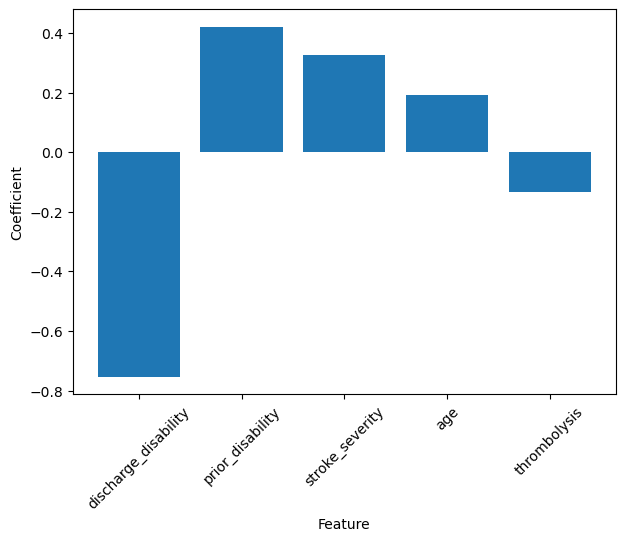


          Average MAE: 1.048270786
          Average RMSE: 1.375681834
          Average R-squared: 0.177001223
          Average adjusted R-squared: 0.177233764


In [19]:
# Standardised prior to regression
show_regression_results(reg_results)

#### Unstandardised results

**Interpreting the coefficients**

These variables were not standardised, so the coefficients are in their original units.  The coefficients represent the change in the outcome variable, for every one unit increase in the predictor, when the value of all other predictors is held constant. It shows that the relationship remains even when you control for other variables. It does not provide evidence for/against a causal relationship.

Examples:
* **Thrombolysis** coefficient -0.28 means that, on average, if you had thrombolysis, you have a 0.28 improvement in mRS score between discharge and follow-up (association not causal, and of people who were followed up)
* **Discharge disability** coefficient -0.51 means having a one mRS score higher discharge disability associates with an improvement of 0.51 in mRS score between discharge and follow-up

**Interpreting the metrics**

These are the same as the metrics when unstandardised variables were used. Why is that?
* Is it because scikit learn standardise for you anyway? No, they don't do this, we checked the documentation and model code.
* Is it as this is a large dataset?
* Is it as there isn't huge variation in scales between the variables?

,coef,coef_abs
discharge_disability,-0.513378,0.513378
prior_disability,0.328601,0.328601
thrombolysis,-0.284410,0.284410
stroke_severity,0.050239,0.050239
age,0.014920,0.014920


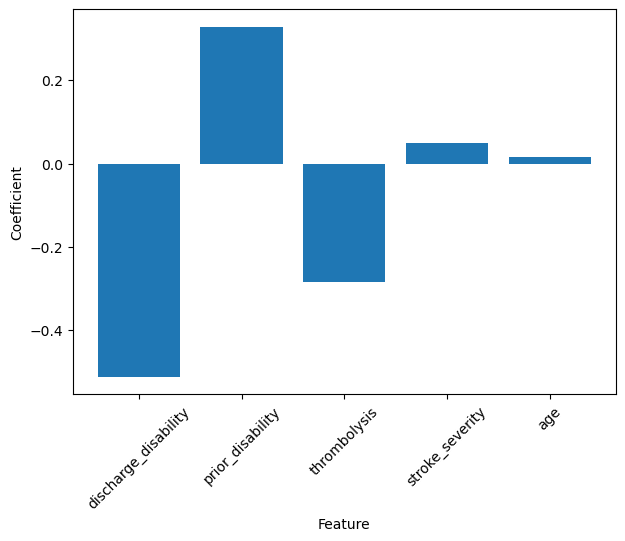


          Average MAE: 1.048270786
          Average RMSE: 1.375681834
          Average R-squared: 0.177001223
          Average adjusted R-squared: 0.177233764


In [20]:
# Did not standardise prior to regression
show_regression_results(reg_results_non_std)

### Assumptions

#### Linearity

We assume there is a linear relationship between predictors and response variable.

You can assess this by looking at the relationship between each individual predictor and outcome variable (but we have 5 predictors, and they are not fully continuous - e.g. thrombolysis is binary, disability is an ordinal scale)

Alternatively, you can assess linearity by looking at the relationship between our predicted values and actual values. Linearity is indicated by an even spread around the diagnoal line. This has been done below.

**Result:** Not necessarily linear

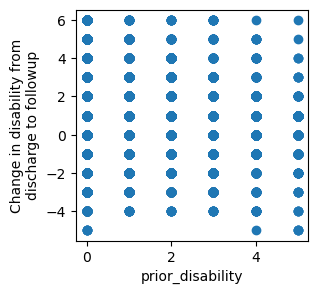

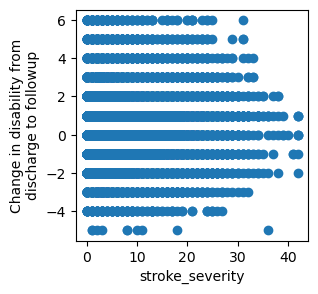

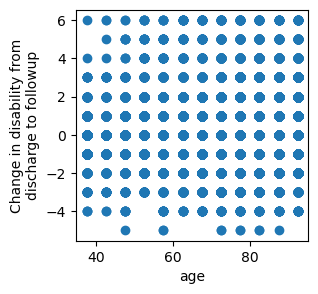

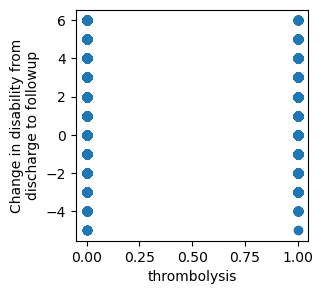

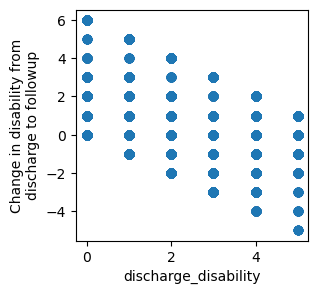

In [21]:
# Look at linear relationship between each predictor and outcome
for i in np.arange(len(X.columns)):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(X.iloc[:, i], y)
    ax.set_xlabel(X.columns[i])
    ax.set_ylabel('Change in disability from\ndischarge to followup')
    plt.show()

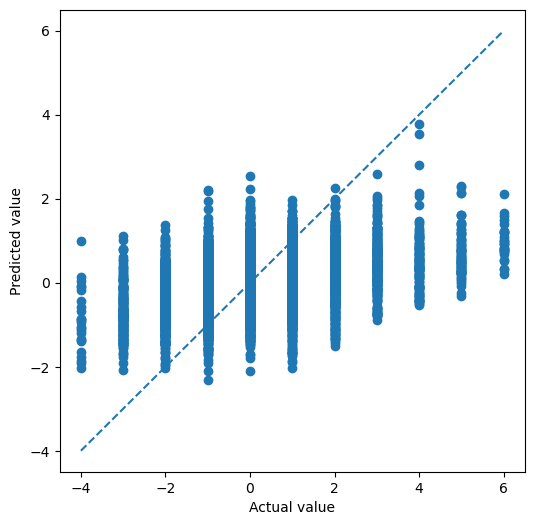

In [22]:
# Look at relationship between actual and predicted values
def test_linear(df):
    '''
    Test assumption of linearity.
    df is dataframe containing columns with predicted and actual
    values of the response variable.
    '''
    # Plot actual and predicted values
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(df['actual'], df['pred'])
    ax.set_xlabel('Actual value')
    ax.set_ylabel('Predicted value')

    # Add diagonal line (based on overall min and max)
    line_coords = (df.min().min(), df.max().max())
    ax.plot(line_coords, line_coords, ls='--')

    plt.show()


# Just plot from first train/test split
test_linear(reg_results['residuals'][0])

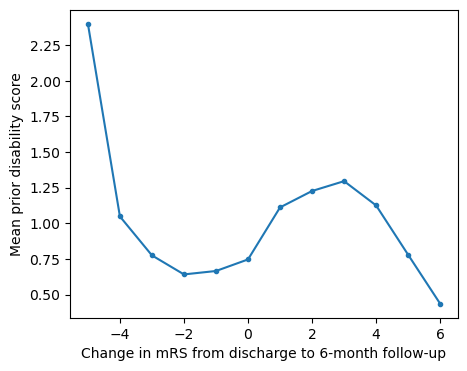

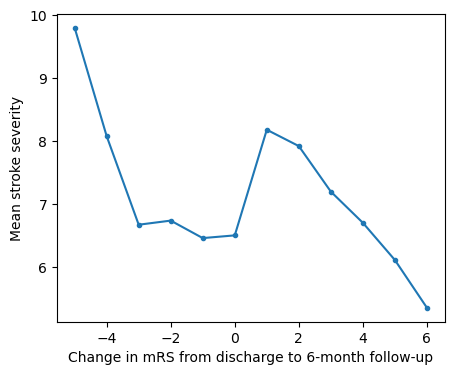

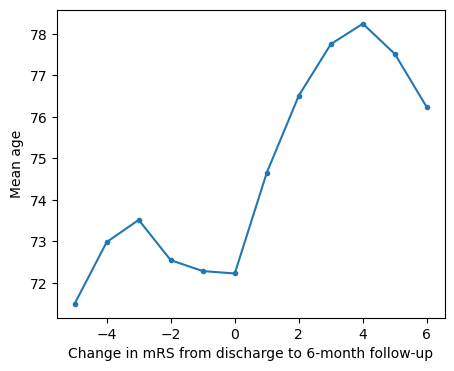

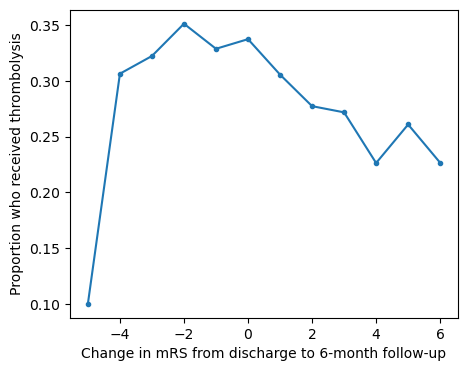

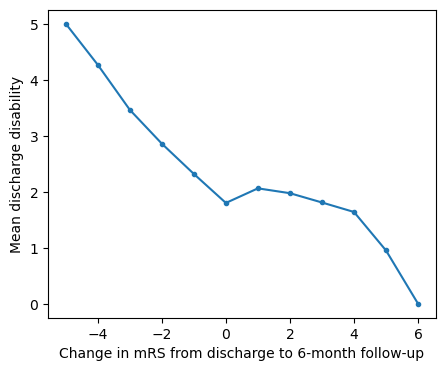

In [23]:
# Look at mean prior disability score, for each change in disability
def plot_averages(column, y_label):
    '''
    Plots the mean result for that column for each group, where the groups
    are the change in disability from discharge to follow-up
    '''
    averages = X.groupby(y)[column].mean()
    fig, ax = plt.subplots(figsize=(5, 4))
    averages.plot(marker='.')
    ax.set_xlabel('Change in mRS from discharge to 6-month follow-up')
    ax.set_ylabel(y_label)
    plt.show()


plot_averages('prior_disability', 'Mean prior disability score')
plot_averages('stroke_severity', 'Mean stroke severity')
plot_averages('age', 'Mean age')
plot_averages('thrombolysis', 'Proportion who received thrombolysis')
plot_averages('discharge_disability', 'Mean discharge disability')

#### Normally distributed residuals

**Result:** Slight left skew

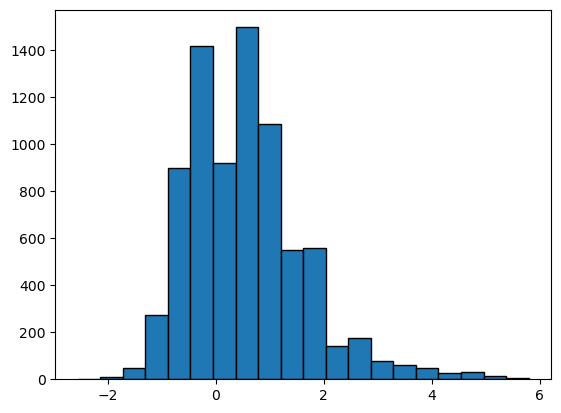

In [24]:
plt.hist(reg_results['residuals'][0]['residuals'], edgecolor='black', bins=20)
plt.show()

#### Independent observations

This is satisfied, as each row is a different patient.

#### Homoscedasticity

Homoscedasticity refers to there being no patterns in distributions of residuals (i.e. size of error doesn't relate to value of outcome variable)

**Result:** No visible patterns

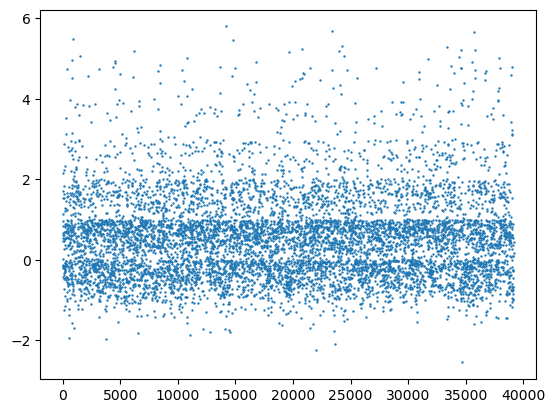

In [25]:
plt.scatter(reg_results['residuals'][0].index,
            reg_results['residuals'][0].residuals,
            s=0.5)
plt.show()

#### No multicolinearity

If there is multicolinearity present, it will result in less precise estimates of individual regression parameters (difficult to decide precisely what each variable contributes) (unstable estimates, may vary alot with addition or removal of data points) (larger sample sizes can better handle multicolinearity)

**Result:** Maximum correlation 0.5 (a moderate positive correlation) (may not be problematic colinearity)

In [26]:
round(X.corr(), 2)

,prior_disability,stroke_severity,age,thrombolysis,discharge_disability
prior_disability,1.00,0.18,0.37,-0.14,0.50
stroke_severity,0.18,1.00,0.08,0.30,0.40
age,0.37,0.08,1.00,-0.08,0.29
thrombolysis,-0.14,0.30,-0.08,1.00,-0.05
discharge_disability,0.50,0.40,0.29,-0.05,1.00


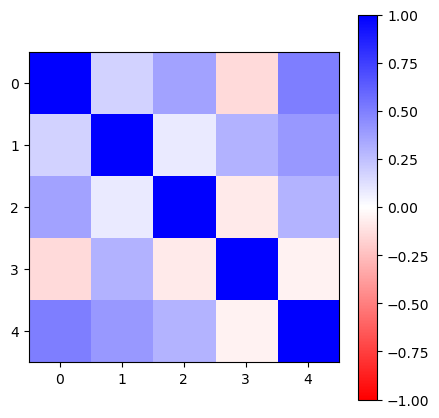

In [27]:
# Create figure object
fig, ax = plt.subplots(figsize=(5, 5))

# Set colours
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    '', ['red', 'white', 'blue'])
norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)

# Create heatmap
heatmap = ax.imshow(X.corr(), cmap=cmap, norm=norm)

# Add legend for colours
fig.colorbar(heatmap)

# Show plot
plt.show()

In [28]:
X.corr()

,prior_disability,stroke_severity,age,thrombolysis,discharge_disability
prior_disability,1.000000,0.176737,0.367022,-0.140884,0.502963
stroke_severity,0.176737,1.000000,0.078893,0.300008,0.400013
age,0.367022,0.078893,1.000000,-0.080770,0.290754
thrombolysis,-0.140884,0.300008,-0.080770,1.000000,-0.052513
discharge_disability,0.502963,0.400013,0.290754,-0.052513,1.000000
